#Data





##Data was collected from Kaggle, and we did manual cleaning because of imbalance

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving model.keras to model (1).keras


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
print(os.listdir('/content/drive/My Drive/dataset_capstone'))



['cleaned_img1.zip']


In [4]:
path = '/content/drive/My Drive/dataset_capstone/cleaned_img1.zip'

In [5]:
import shutil
shutil.unpack_archive(path, '/content')


#Import module

In [6]:
!pip install imbalanced-learn


In [7]:
import os
from PIL import Image
import numpy as np
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomFlip
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping


In [8]:
random.seed(69)

#Prepare data

In [9]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

dataset_path = '/content/cleaned_img'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 1998 files belonging to 10 classes.


#Model

##Split

In [10]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


##Augmentation

In [11]:
def create_augmentation_model():

    augmentation_model = tf.keras.Sequential([
		tf.keras.Input(shape=(224,224,3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2)
        ])


    return augmentation_model

##CNN

In [12]:
augmentation_layers = create_augmentation_model()
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    augmentation_layers,
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(11, activation='softmax')
])


def one_hot_encode_image(image, label):
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, depth=11)
    return image, label


train_dataset = train_dataset.map(one_hot_encode_image)
val_dataset = val_dataset.map(one_hot_encode_image)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,166,939 (27.34 MB)

 Trainable params: 7,165,947 (27.34 MB)

 Non-trainable params: 992 (3.88 KB)

##Train

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 348ms/step - accuracy: 0.1900 - loss: 20.1369 - val_accuracy: 0.1055 - val_loss: 18.8334
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.3316 - loss: 18.3182 - val_accuracy: 0.1256 - val_loss: 18.9082
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.3739 - loss: 17.7742 - val_accuracy: 0.1533 - val_loss: 18.4891
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.3911 - loss: 17.1681 - val_accuracy: 0.1533 - val_loss: 17.9033
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.4366 - loss: 16.7066 - val_accuracy: 0.1834 - val_loss: 17.1946
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.4067 - loss: 16.1847 - val_accuracy: 0.2940 - val_loss: 16.4295
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.4485 - loss: 15.7085 - val_accuracy: 0.3266 - val_loss: 15.8630
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.4724 - loss: 15.

##Graph

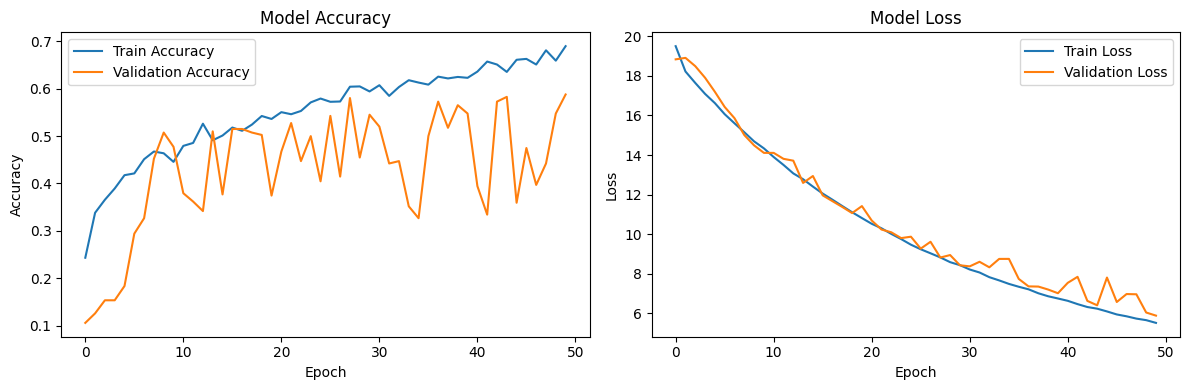

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Save

In [ ]:
model.save('model.keras')


In [ ]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin